In [1]:
import pandas as pd
import time
from skimage import io
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np

start = time.time()

In [2]:
pre_image = io.imread('../NPP001_Pre.tif')
fin_image = io.imread('../NPP001_fin.tif')

In [3]:
vmin=pre_image.min()
vmax=pre_image.max()

# pre_x_min = 200
# pre_x_max = 3000-2000
# pre_y_min = 1500+1000
# pre_y_max = 4000-1000

# fin_x_min = 200
# fin_x_max = 3000-2000
# fin_y_min = 1500+1000
# fin_y_max = 4000-1000

pre_x_min = 0
pre_x_max = min(pre_image.shape[1], fin_image.shape[1])
pre_y_min = 0
pre_y_max = min(pre_image.shape[0], fin_image.shape[0])

fin_x_min = 0
fin_x_max = min(pre_image.shape[1], fin_image.shape[1])
fin_y_min = 0
fin_y_max = min(pre_image.shape[0], fin_image.shape[0])

bkg_subtract = np.subtract(pre_image[fin_y_min:fin_y_max, fin_x_min:fin_x_max].astype('int16'),
                           fin_image[pre_y_min:pre_y_max, pre_x_min:pre_x_max].astype('int16'))

bkg_subtract[bkg_subtract < 0] = 0
bkg_subtract = bkg_subtract.astype('uint8')

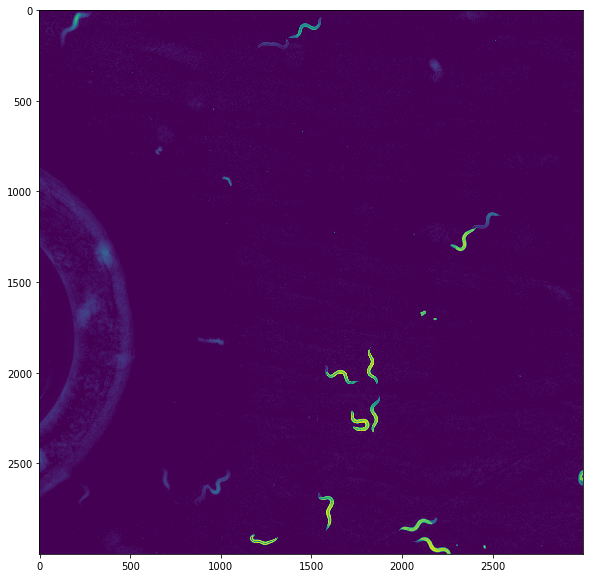

In [4]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(bkg_subtract[1000:4000, 2000:5000])#, vmin=vmin, vmax=vmax)

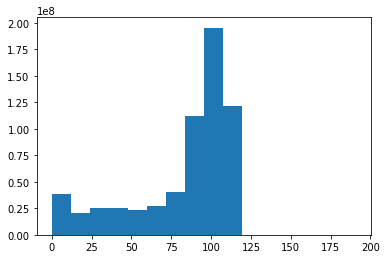

In [5]:
plt.hist(pre_image.flatten(), bins=16)
plt.show()

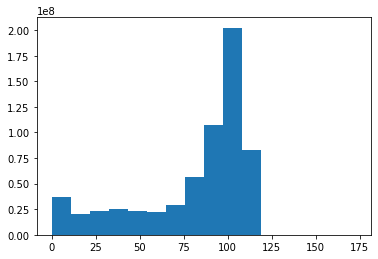

In [6]:
plt.hist(fin_image.flatten(), bins=16)
plt.show()

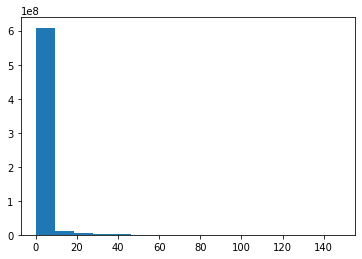

In [7]:
plt.hist(bkg_subtract.flatten(), bins=16, ylim=())
plt.show()

In [8]:
print('Notebook ran in', str(int(time.time()-start)), 'seconds.')

Notebook ran in 85 seconds.
